In [1]:
import zipfile
import os
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
# Define the file paths for accessing within the Codespace
base_path = "/workspaces/MLZOOMCAMP_2024/Others"
zip_file_path = os.path.join(base_path, "bank+marketing.zip")
inner_zip_file = "bank.zip"
csv_file = "bank-full.csv"

# Open the outer zip file
with zipfile.ZipFile(zip_file_path, 'r') as outer_zip:
    # Extract the inner zip file (bank.zip)
    with outer_zip.open(inner_zip_file) as inner_zip_stream:
        # Create a ZipFile object for the inner zip file
        with zipfile.ZipFile(io.BytesIO(inner_zip_stream.read())) as inner_zip:
            # Extract the CSV file from the inner zip file
            with inner_zip.open(csv_file) as file:
                df = pd.read_csv(file, sep=';')

# Display the first few rows of the DataFrame
columns = ["age", "job", "marital", "education", "balance", "housing", "contact", "day", "month", "duration", "campaign", "pdays", "previous", "poutcome", "y"]

df = df[columns]
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [2]:
# Data Splitting
# Target Encoding

df['y'] = (df['y'] == 'yes').astype(int)


#Train_Test_Split
from sklearn.model_selection import train_test_split
X = df.copy()

X_train_full, X_test = train_test_split(X, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val = train_test_split(X_train_full, test_size=0.25, random_state=42, shuffle=True)

df_train_full = X_train_full.reset_index(drop=True)
df_train = X_train.reset_index(drop=True)
df_val = X_val.reset_index(drop =True)
df_test = X_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']                                                    

In [3]:

from sklearn.metrics import *
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression



def train_and_evaluate(train, val, y_train, y_val, features):
    train_dict = train[features].to_dict(orient='records')
    val_dict = val[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    x_train = dv.fit_transform(train_dict)
    x_val = dv.transform(val_dict)

    # Train logistic regression model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(x_train, y_train)

    # Predict on validation set
    y_pred = model.predict(x_val)

    # Calculate accuracy
    return roc_auc_score(y_val, y_pred)

def train_and_evaluate_allfeat(train, val, y_train, y_val):
    train_dict = train.to_dict(orient='records')
    val_dict = val.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    x_train = dv.fit_transform(train_dict)
    x_val = dv.transform(val_dict)

    # Train logistic regression model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(x_train, y_train)

    # Predict on validation set
    y_pred = model.predict(x_val)

    return roc_auc_score(y_val, y_pred)


In [4]:
#ROC AUC feature importance

feat = ['balance', 'day', 'duration', 'previous']
score = {}

for n in feat:
    aucscore = roc_auc_score(y_train, df_train[n])
    if aucscore < 0.5:
        aucscore = roc_auc_score(y_train, -df_train[n])
    score[n] = aucscore

max_score = max(score, key=score.get)
print(f"The numerical variable with the highest AUC is: {max_score} with an AUC of {score[max_score]}")


The numerical variable with the highest AUC is: duration with an AUC of 0.8065630842212128


In [5]:
# Logistic regression and auc_score

scores = train_and_evaluate_allfeat(df_train, df_val, y_train, y_val)
auc_scores = round(scores, 3)
auc_scores

0.662

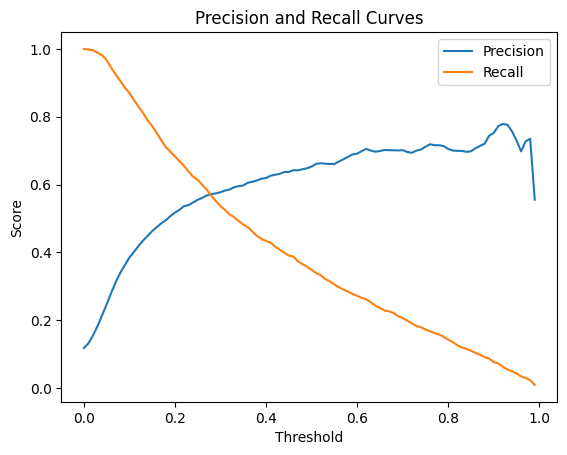

Precision and recall curves intersect at approximately threshold: 0.28


In [6]:
# Function to train and evaluate logistic regression model
def train_and_evaluate_allfeat1(train, val, y_train, y_val):
    train_dict = train.to_dict(orient='records')
    val_dict = val.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    x_train = dv.fit_transform(train_dict)
    x_val = dv.transform(val_dict)

    # Train logistic regression model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(x_train, y_train)

    # Predict probabilities on validation set
    y_pred = model.predict_proba(x_val)[:, 1]
    return y_pred

# Generate thresholds between start and stop
thresh = np.arange(0.0, 1.0, 0.01)

# Train the model and get prediction probabilities
y_pred = train_and_evaluate_allfeat1(df_train, df_val, y_train, y_val)

# Initialize lists to store precision and recall scores
pre_scores = []
rec_scores = []

for t in thresh:
    # Binarize predictions based on the threshold
    y_pred_binary = (y_pred >= t).astype(int)
    
    # Compute precision and recall scores
    pre_score = precision_score(y_val, y_pred_binary)
    rec_score = recall_score(y_val, y_pred_binary)
    
    # Append the scores to the lists
    pre_scores.append(pre_score)
    rec_scores.append(rec_score)

plt.plot(thresh, pre_scores, label='Precision')
plt.plot(thresh, rec_scores, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall Curves')
plt.legend()
plt.show()


intersection_threshold = None
min_diff = float('inf')

for i in range(len(thresh)):
    diff = abs(pre_scores[i] - rec_scores[i])
    if diff < min_diff:
        min_diff = diff
        intersection_threshold = thresh[i]

print(f"Precision and recall curves intersect at approximately threshold: {intersection_threshold:.2f}")

In [7]:
# F1 Score

F1_score = []

for t in thresh:
    # Binarize predictions based on the threshold
    y_pred_binary = (y_pred >= t).astype(int)
    
    # Compute precision and recall scores
    pre_score = precision_score(y_val, y_pred_binary)
    rec_score = recall_score(y_val, y_pred_binary)
    
    # Compute F1 score using the formula
    if pre_score + rec_score > 0:  # Avoid division by zero
        f1 = 2 * (pre_score * rec_score) / (pre_score + rec_score)
    else:
        f1 = 0

    F1_score.append(f1)

# Find the threshold where F1 score is maximum
max_f1 = max(F1_score)
optimal_threshold = thresh[F1_score.index(max_f1)]

print(f"Maximum F1 score: {max_f1:.3f} at threshold: {optimal_threshold:.3f}")

Maximum F1 score: 0.590 at threshold: 0.220


In [8]:
#KFOLD

from tqdm.auto import tqdm


from sklearn.model_selection import KFold
import numpy as np

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []
C = 1.0  

# Iterate over the K-Folds
for train_idx, val_idx in tqdm(kfold.split(df_train_full), total=kfold.get_n_splits()):
    # Split the data into training and validation sets
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    # One-hot encode the features using DictVectorizer
    dv = DictVectorizer(sparse=False)
    train_dict = df_train.drop('y', axis=1).to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    
    val_dict = df_val.drop('y', axis=1).to_dict(orient='records')
    X_val = dv.transform(val_dict)

    # Train the Logistic Regression model
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    # Predict probabilities for validation set
    y_pred = model.predict_proba(X_val)[:, 1]

    # Calculate AUC score for validation set
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

# Output the mean and standard deviation of AUC scores
print(f'C={C} Mean AUC: {np.mean(scores):.3f} +- {np.std(scores):.3f}')

  0%|          | 0/5 [00:00<?, ?it/s]

C=1.0 Mean AUC: 0.906 +- 0.008


In [9]:
# Hyperparameter tunning

# C values to test
C_values = [0.000001, 0.001, 1]

# Initialize KFold with 5 splits
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

best_mean_auc = 0
best_std_auc = float('inf')
best_C = None

# Iterate over each value of C
for C in C_values:
    print(f"Evaluating C={C}")
    
    scores = []
    
    # Iterate over the K-Folds
    for train_idx, val_idx in tqdm(kfold.split(df_train_full), total=kfold.get_n_splits()):
        # Split the data into training and validation sets
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        # One-hot encode the features using DictVectorizer
        dv = DictVectorizer(sparse=False)
        train_dict = df_train.drop('y', axis=1).to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)

        val_dict = df_val.drop('y', axis=1).to_dict(orient='records')
        X_val = dv.transform(val_dict)

        # Train the Logistic Regression model with the current C
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        # Predict probabilities for validation set
        y_pred = model.predict_proba(X_val)[:, 1]

        # Calculate AUC score for validation set
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    # Compute the mean and standard deviation of AUC scores for the current C
    mean_auc = np.mean(scores)
    std_auc = np.std(scores)

    print(f'C={C}: Mean AUC={mean_auc:.3f}, Std AUC={std_auc:.3f}')
    
    # Update the best C based on mean AUC, and then by std_auc in case of ties
    if (mean_auc > best_mean_auc) or (mean_auc == best_mean_auc and std_auc < best_std_auc):
        best_mean_auc = mean_auc
        best_std_auc = std_auc
        best_C = C

# Print the best C value and its corresponding mean and std
print(f'Best C={best_C} with Mean AUC={best_mean_auc:.3f} and Std AUC={best_std_auc:.3f}')

Evaluating C=1e-06


  0%|          | 0/5 [00:00<?, ?it/s]

C=1e-06: Mean AUC=0.695, Std AUC=0.009
Evaluating C=0.001


  0%|          | 0/5 [00:00<?, ?it/s]

C=0.001: Mean AUC=0.861, Std AUC=0.006
Evaluating C=1


  0%|          | 0/5 [00:00<?, ?it/s]

C=1: Mean AUC=0.906, Std AUC=0.008
Best C=1 with Mean AUC=0.906 and Std AUC=0.008
